In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
sns.set()

In [6]:
np.random.seed(123)
#mv volatility is being used here
x = np.linspace(0, 0.4112, 200)
#SOX parent volatility is being used here
y = (stats.gamma.pdf(x, a=2, loc=0, scale=17) + np.random.normal(0,86.83,200)) * 1000
x = x.reshape(-1,1)

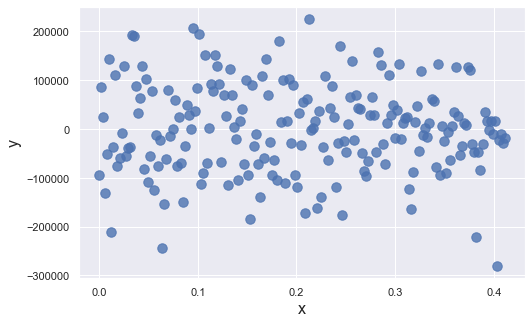

In [7]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.scatter(x, y, s=90, alpha=0.8)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()

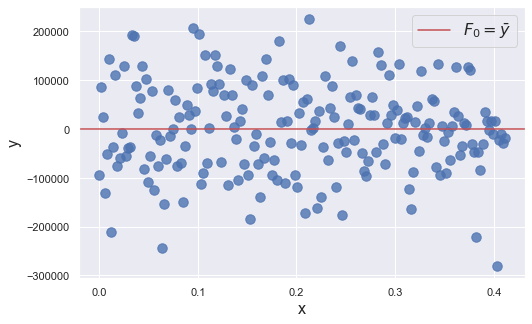

In [8]:
plt.scatter(x, y, s=90, alpha=0.8)
plt.axhline(y=y.mean(), color='r', linestyle='-', label=r'$F_{0} = \bar{y}$')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=16)
plt.show()

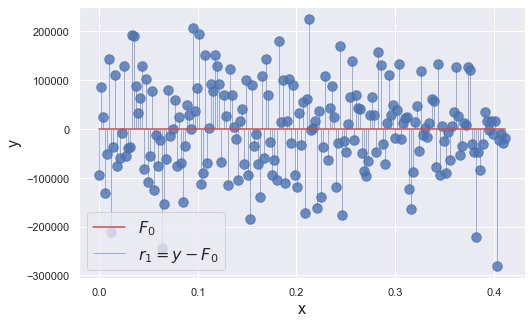

In [9]:
def plot_residuals(x, y, Fm, i, ax, title = ''):
    fltr_smaller = y < Fm
    fltr_bigger = y >= Fm
    
    ax.scatter(x, y, s=90, alpha=0.8)
    ax.plot(x, Fm, c='r', label=f'$F_{i}$')
    ax.vlines(x[fltr_smaller], y[fltr_smaller], Fm[fltr_smaller], linewidth=0.5, color='b', label=f'$r_{i+1} = y - F_{i}$')
    ax.vlines(x[fltr_bigger], Fm[fltr_bigger], y[fltr_bigger], linewidth=0.5, color='b')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    ax.legend(fontsize=16)

fig, ax = plt.subplots(1, 1)
F0 = np.full(len(y), y.mean())
plot_residuals(x, y, F0, 0, ax)
plt.show()

In [10]:
def print_tree(clf):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True
    print('-'*80)
    print(
        "the binary tree structure has {n} nodes and has "
        "the following tree structure: \n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node.".format(
                    space=node_depth[i] * "\t", node=i
                )
            )
            print(node_depth[i] * '\t', f"prediction: {clf.tree_.value[i, 0, 0]:.1f}")
        else:
            print(
                "{space}node={node} is a spilt node: "
                "go to node {left} if X[:, {feature}] <= {threshold} "
                "else to node {right}.".format(
                    space= node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature[i],
                    threshold=threshold[i],
                    right=children_right[i],
                )
            )
        print('-'*80)

In [11]:
def train_and_update(x, y, Fm, learning_rate=0.1):
    r = y - Fm
    tree = DecisionTreeRegressor(max_depth=1, random_state=0)
    tree.fit(x, r)
    gamma = tree.predict(x)
    Fm = Fm +learning_rate * gamma
    
    return tree, Fm, gamma, r

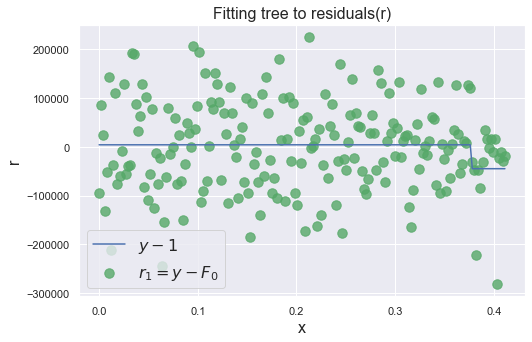

--------------------------------------------------------------------------------
the binary tree structure has 3 nodes and has the following tree structure: 

node=0 is a spilt node: go to node 1 if X[:, 0] <= 0.3771055191755295 else to node 2.
--------------------------------------------------------------------------------
	node=1 is a leaf node.
	 prediction: 4162.1
--------------------------------------------------------------------------------
	node=2 is a leaf node.
	 prediction: -44803.3
--------------------------------------------------------------------------------


In [12]:
def plot_gamma(x, residuals, gamma, i, ax, title = ""):
    
    ax.scatter(x, residuals, color = 'g', s=90, alpha=0.8, label=f'$r_{i} = y - F_{i-1}$')
    ax.plot(x, gamma, c='b', label=f'$y-{i}$')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("x", fontsize=16)
    ax.set_ylabel("r", fontsize=16)
    ax.legend(fontsize=16)
    
tree, Fm, gamma, r = train_and_update(x, y, F0, learning_rate=0.9)

fig, ax = plt.subplots(1, 1)
plot_gamma(x, r, gamma, 1, ax, "Fitting tree to residuals(r)")
plt.show()
print_tree(tree)

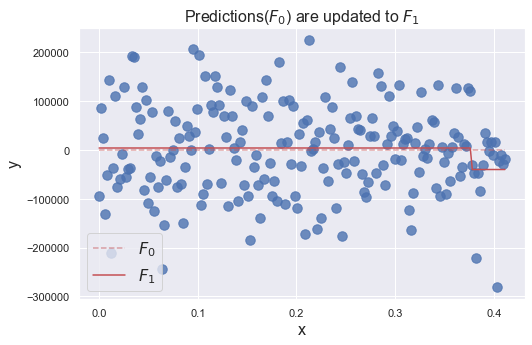

In [13]:
def plot_update(x, y, Fm, Fm_pre, i):
    plt.scatter(x, y, s=90, alpha=0.8)
    plt.plot(x, Fm_pre, c='r', linestyle='--', label=f'$F_{i-1}$', alpha=0.5)
    plt.plot(x, Fm, c='r', label=f'$F_{i}$')
    plt.title(f"Predictions($F_{i-1}$) are updated to $F_{i}$", fontsize=16)
    plt.xlabel("x", fontsize=16)
    plt.ylabel("y", fontsize=16)
    plt.legend(fontsize=16)
    plt.show()
    
plot_update(x, y, Fm, F0, 1)

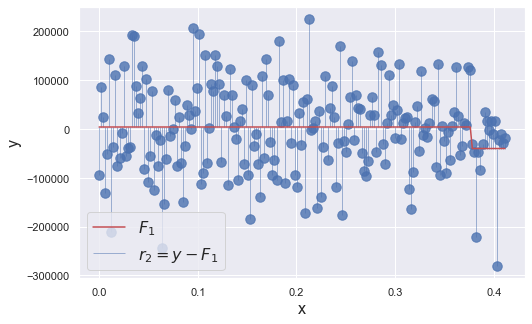

In [14]:
fig, ax = plt.subplots(1, 1)
plot_residuals(x, y, Fm, 1, ax)
plt.show()

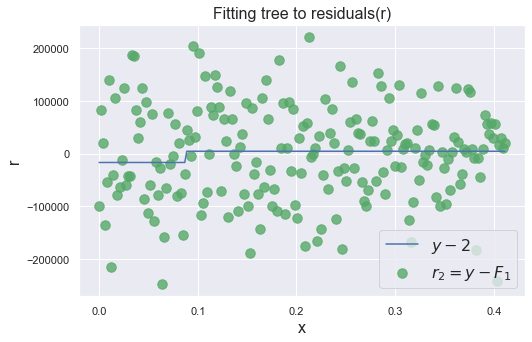

--------------------------------------------------------------------------------
the binary tree structure has 3 nodes and has the following tree structure: 

node=0 is a spilt node: go to node 1 if X[:, 0] <= 0.08781909570097923 else to node 2.
--------------------------------------------------------------------------------
	node=1 is a leaf node.
	 prediction: -16714.3
--------------------------------------------------------------------------------
	node=2 is a leaf node.
	 prediction: 4577.8
--------------------------------------------------------------------------------


In [15]:
Fm_pre = Fm.copy()
tree, Fm, gamma, r = train_and_update(x, y, Fm, learning_rate=0.9)

fig, ax = plt.subplots(1, 1)
plot_gamma(x, r, gamma, 2, ax, "Fitting tree to residuals(r)")
plt.show()
print_tree(tree)

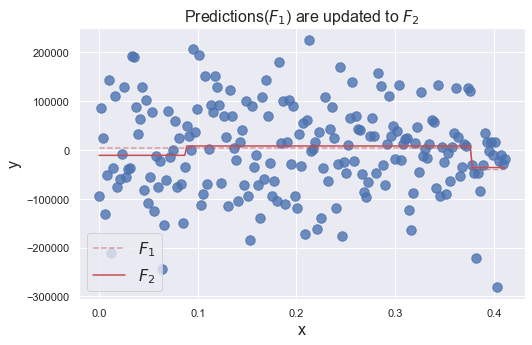

In [16]:
plot_update(x, y, Fm, Fm_pre, 2)

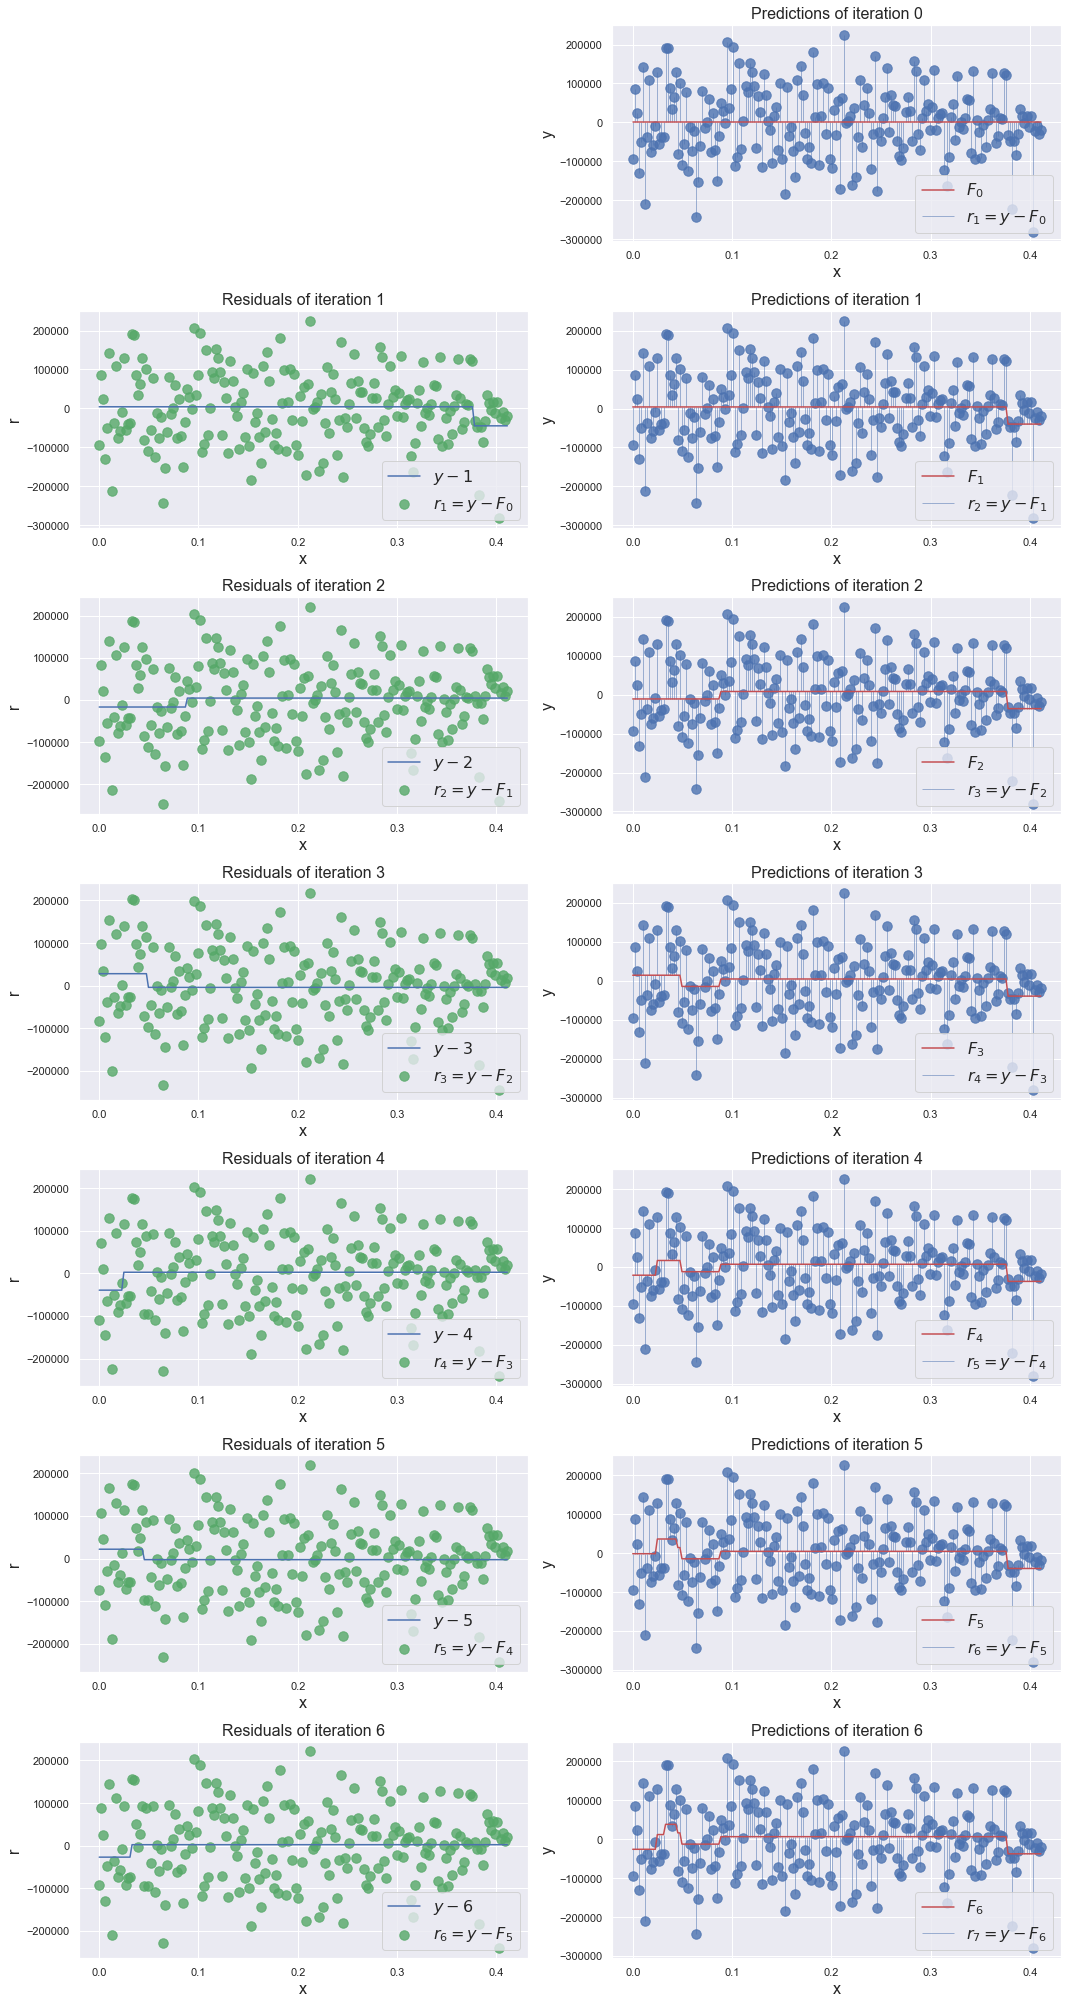

In [17]:
Fm = F0 = np.full(len(y), y.mean())
n_estimators = 6

fig, axs = plt.subplots(n_estimators+1, 2, figsize=(15, 4*(n_estimators+1)))
axs = axs.flatten()
axs[0].axis('off')

plot_residuals(x, y, F0, 0, axs[1], title="Predictions of iteration 0")

for i in range(n_estimators):
    tree, Fm, gamma, r = train_and_update(x, y, Fm, learning_rate=0.9)
    
    j = 2 + i*2
    plot_gamma(x, r, gamma, i+1, axs[j], f"Residuals of iteration {i+1}")
    plot_residuals(x, y, Fm, i+1, axs[j+1], title=f"Predictions of iteration {i+1}")
    
plt.tight_layout()
plt.show()

In [18]:
class CustomGradientBoostingRegressor:
    def __init__(self, learning_rate, n_estimators, max_depth=1):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        
    def fit(self, X, y):
        self.F0 = y.mean()
        Fm = self.F0
        
        for _ in range(self.n_estimators):
            r = y - Fm
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=0)
            tree.fit(X, r)
            gamma = tree.predict(X)
            Fm += self.learning_rate * gamma
            self.trees.append(tree)
            
    def predict(self, X):
        
        Fm = self.F0
        
        for i in range(self.n_estimators):
            Fm += self.learning_rate * self.trees[i].predict(X)
            
        return Fm

In [19]:
from sklearn.metrics import mean_squared_error
custom_gbm = CustomGradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.2, 
    max_depth=10
)
custom_gbm.fit(x, y)
custom_gbm_rmse = mean_squared_error(y, custom_gbm.predict(x), squared=False)
print(f'Custom GBM RMSE: {custom_gbm_rmse:.15f}')

Custom GBM RMSE: 5.907657655064314
